In [11]:
import csv
import math
import heapq
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

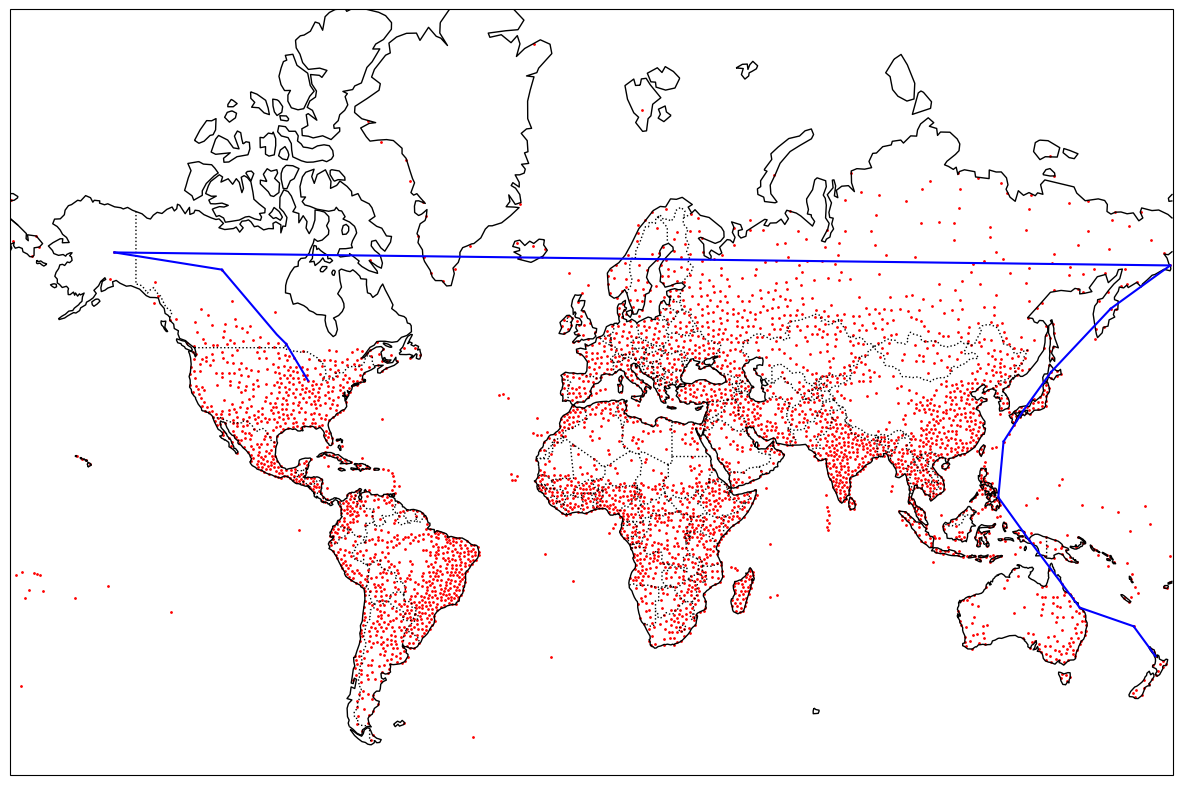

In [12]:
# Load cities from csv
cities = {}
with open('filtered_cities.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        city_ascii = row['city_ascii']
        lat = float(row['lat'])
        lng = float(row['lng'])
        cities[city_ascii] = (lat, lng)


#Distance finder function
def haversine(coord1, coord2):
    R = 6371
    dlat = math.radians(coord2[0] - coord1[0])
    dlon = math.radians(coord2[1] - coord1[1])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(coord1[0])) * math.cos(math.radians(coord2[0])) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    return distance

def a_star_search(start_city, end_city, cities_dict, distance_threshold=1000):
    # Lookup city coordinates directly from the dictionary
    start_coords = cities_dict[start_city]
    end_coords = cities_dict[end_city]
    
    open_set = [(0, start_coords)]
    came_from = {}
    g_score = {coord: float('inf') for coord in cities_dict.values()}
    g_score[start_coords] = 0
    f_score = {coord: float('inf') for coord in cities_dict.values()}
    f_score[start_coords] = haversine(start_coords, end_coords)

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == end_coords:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(current)
            return path[::-1]

        for neighbor in cities_dict.values():
            dist = haversine(current, neighbor)
            if dist > distance_threshold:
                continue

            tentative_g_score = g_score[current] + dist
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + haversine(neighbor, end_coords)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []

def total_path_distance(path):
    return sum(haversine(path[i], path[i+1]) for i in range(len(path)-1))

def location_by_percentage(path, percentage):
    total_distance = total_path_distance(path)
    desired_distance = (percentage / 100) * total_distance
    
    cumulative_distance = 0
    for i in range(len(path) - 1):
        segment_distance = haversine(path[i], path[i+1])
        if cumulative_distance + segment_distance >= desired_distance:
            # Linear interpolation to estimate the position along the segment
            t = (desired_distance - cumulative_distance) / segment_distance
            lat = path[i][0] + t * (path[i+1][0] - path[i][0])
            lng = path[i][1] + t * (path[i+1][1] - path[i][1])
            return (lat, lng)
        
        cumulative_distance += segment_distance

    return path[-1]  # Return the end location if the percentage is 100 or more



#Plot size
plt.figure(figsize=(15, 12))
#Projection type
ax = plt.axes(projection=ccrs.Mercator())
#Add features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
#Draw cities
ax.scatter([lng for _, (lat, lng) in cities.items()], [lat for _, (lat, lng) in cities.items()], color="red", s=1, transform=ccrs.PlateCarree())

#Run a*
path = a_star_search("Auckland", "Chicago", cities, distance_threshold=2000)

for i in range(len(path)-1):
    ax.plot([path[i][1], path[i+1][1]], [path[i][0], path[i+1][0]], color='blue', transform=ccrs.PlateCarree())

plt.show()

percentage = float(50)  # Taking input from the user
location = location_by_percentage(path, percentage)

# Plot the percentage location on the map
ax.scatter(location[1], location[0], color="green", s=100, transform=ccrs.PlateCarree(), zorder=5)  # zorder is used to ensure the marker is on top
